In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize, OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph

import warnings
warnings.filterwarnings("ignore")

In [2]:
file_path = './data/df_movies_4kmeans.csv'
df = pd.read_csv(file_path)
df.drop(columns=['title','time_of_day_4','time_of_day_1','time_of_day_2','time_of_day_3','NPS','Year','age_movie_when_rated','age_movie_when_rated'], inplace=True)
df.drop(columns=['weekday_0','weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6','imdbId','imdbVotes','awards_total','voting_count'], inplace=True)
df.drop(columns=['avg_rate'], inplace=True)
df.dropna(inplace=True)
# df.columns
df.head()

,movieId,age_movie_in_2019,imdbRating,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,1,24.0,8.3,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,24.0,7.0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,24.0,6.7,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,4,24.0,5.9,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
4,5,24.0,6.1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [3]:
# Apply one-hot encoding to the 'ID' column
onehot_encoder = OneHotEncoder()
id_encoded = onehot_encoder.fit_transform(df[['movieId']])

# Data preprocessing
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.drop(columns=['movieId']))
# scaled_data
# # Concatenate the encoded 'ID' column with the scaled data
# scaled_data_with_id = np.concatenate([scaled_data, id_encoded], axis=1)

In [4]:
# Applying K-means clustering
kmeans_inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    kmeans_inertia.append(kmeans.inertia_)

# Plotting the elbow curve to find the suitable choice of K for K-means
# plt.plot(range(1, 11), kmeans_inertia, marker='o')
# plt.xlabel('Number of clusters (K)')
# plt.ylabel('Within-cluster sum of squares (Inertia)')
# plt.title('Elbow Method for Optimal K (K-means)')
# plt.show()

# Applying Gaussian Mixture Model (GMM) clustering
bic_scores = []
for k in range(1, 11):
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(scaled_data)
    bic_scores.append(gmm.bic(scaled_data))

# Plotting the BIC scores to find the suitable choice of K for GMM
# plt.plot(range(1, 11), bic_scores, marker='o')
# plt.xlabel('Number of clusters (K)')
# plt.ylabel('BIC Score')
# plt.title('BIC Score for Optimal K (GMM)')
# plt.show()

In [5]:
scaled_data.shape

(58851, 29)

In [6]:
# K-means clustering with K=7
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)

# Plotting K-means clusters
# plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=kmeans_labels, cmap='viridis')
# plt.title('K-means Clustering')
# plt.xlabel('Feature 1 (age)')
# plt.ylabel('Feature 2 (rating)')
# plt.tight_layout()
# plt.colorbar(label='Cluster Number')
# plt.show()

In [7]:
# GMM clustering with K=5
gmm = GaussianMixture(n_components=5, random_state=42)
gmm_labels = gmm.fit_predict(scaled_data)

# Plotting GMM clusters
for i in range(len(gmm.means_)):
    probs = gmm.predict_proba(scaled_data)
    # plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=probs[:, i], cmap='viridis', alpha=0.8)
    # plt.colorbar(label='Probability')
    # plt.title(f'GMM Clustering Cluster {i+1}')
    # plt.xlabel('Feature 1 (age)')
    # plt.ylabel('Feature 2 (rating)')

    # plt.tight_layout()
    # plt.show()

In [8]:
pca = PCA(n_components=2)  # Reduce to 2 dimensions

# Fit PCA
pca.fit(scaled_data)

# Transform data
df_reduced = pca.transform(scaled_data)

# Convert transformed data to dataframe
df_red = pd.DataFrame(df_reduced, columns=['PC1', 'PC2'])

print(df_red.head())

        PC1       PC2
0  5.419845  2.791905
1  3.440879  2.275453
2  0.772582 -0.500464
3  0.267650 -0.738229
4  2.167171  0.408216


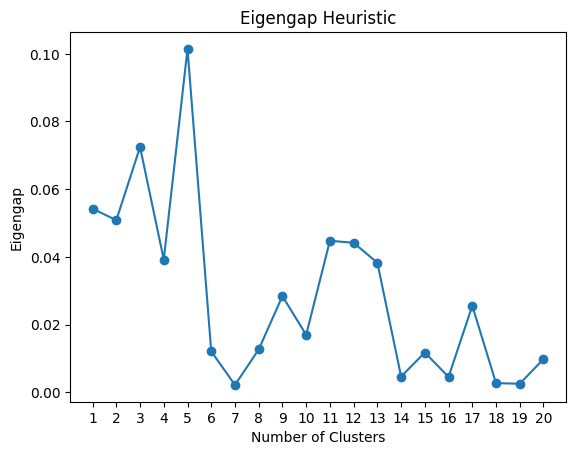

5


In [9]:
# Calculate the similarity matrix (e.g., using k-nearest neighbors graph)
df_red_samp = df_red.sample(frac=1,random_state=47).iloc[:4000,:]
similarity_matrix = kneighbors_graph(df_red_samp, n_neighbors=10, mode='connectivity', include_self=True)

# Convert the similarity matrix to a dense array
similarity_matrix = similarity_matrix.toarray()

# Calculate the degree matrix
degree_matrix = np.diag(np.sum(similarity_matrix, axis=1))

# Calculate the Laplacian matrix
laplacian_matrix = degree_matrix - similarity_matrix

# Compute eigenvectors and eigenvalues
eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)

# Sort eigenvalues in ascending order
sorted_indices = np.argsort(eigenvalues)
sorted_eigenvalues = eigenvalues[sorted_indices]

# Compute eigengaps
eigengaps = np.diff(sorted_eigenvalues)
eigengaps = eigengaps[:20]

# Find the index of maximum eigengap
optimal_k_index = np.argmax(eigengaps)

# Plot eigengaps
plt.plot(range(1, len(eigengaps) + 1), eigengaps, marker='o')
plt.title('Eigengap Heuristic')
plt.xlabel('Number of Clusters')
plt.ylabel('Eigengap')
plt.xticks(np.arange(1, len(eigengaps) + 1, step=1))  # Adjust step value as needed
plt.show()

optimal_k = optimal_k_index + 1
print(optimal_k)

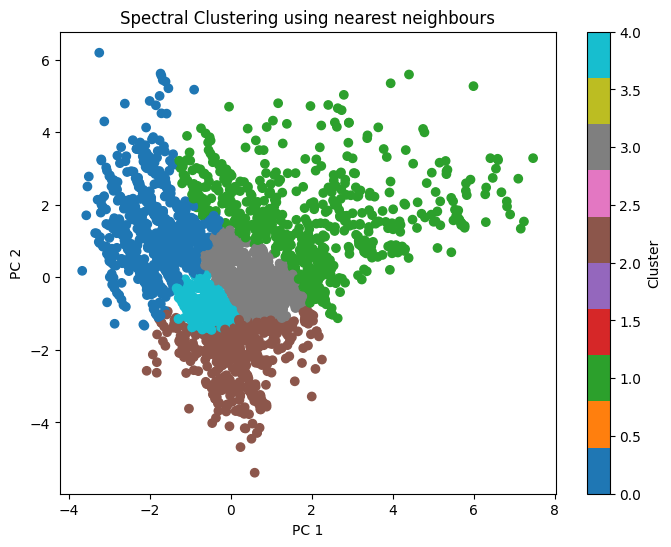

In [10]:
# using nearest_neighbors
spectral_clustering = SpectralClustering(n_clusters=optimal_k, affinity='nearest_neighbors')
nn_labels = spectral_clustering.fit_predict(df_red_samp)

plt.figure(figsize=(8, 6))
plt.scatter(df_red_samp['PC1'], df_red_samp['PC2'], c=nn_labels, cmap='tab10')
plt.title('Spectral Clustering using nearest neighbours')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar(label='Cluster')
plt.show()

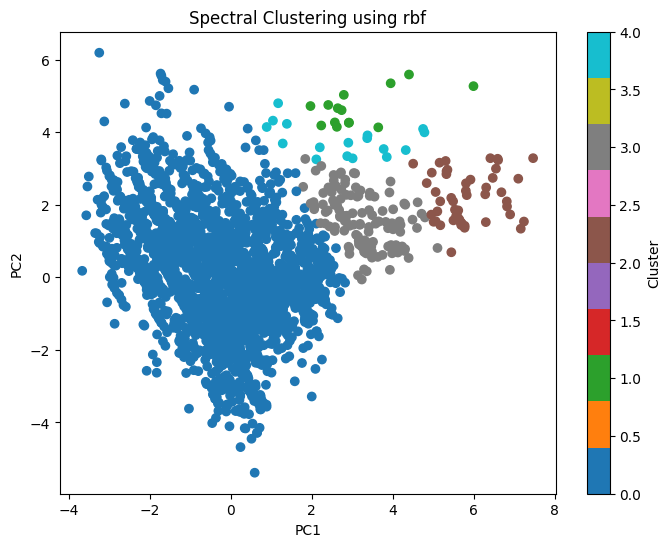

In [11]:
# using rbf
spectral_clustering = SpectralClustering(n_clusters=optimal_k, affinity='rbf')
rbf_labels = spectral_clustering.fit_predict(df_red_samp)

plt.figure(figsize=(8, 6))
plt.scatter(df_red_samp['PC1'], df_red_samp['PC2'], c=rbf_labels, cmap='tab10')
plt.title('Spectral Clustering using rbf')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.show()

Silhouette Score for 'nearest_neighbors' affinity: 0.2698834721969882
Silhouette Score for 'rbf' affinity: 0.44986411672102855


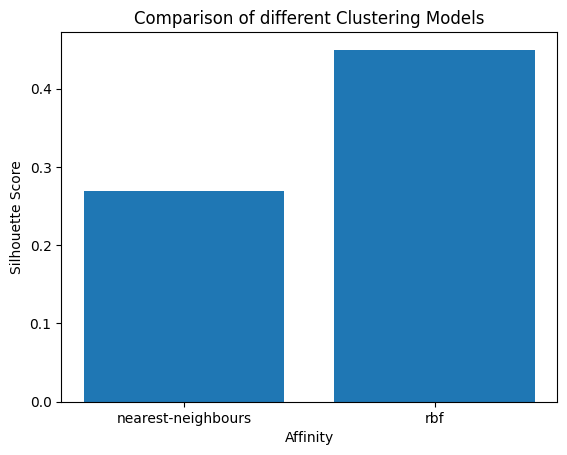

In [12]:
affinity = ['nearest-neighbours', 'rbf']
s_scores = []
s_scores.append(silhouette_score(df_red_samp, nn_labels))
s_scores.append(silhouette_score(df_red_samp, rbf_labels))
print("Silhouette Score for 'nearest_neighbors' affinity:", s_scores[0])
print("Silhouette Score for 'rbf' affinity:", s_scores[1])

# Plotting Bar Graph to compare the Models
plt.bar(affinity, s_scores)
plt.xlabel('Affinity')
plt.ylabel('Silhouette Score')
plt.title('Comparison of different Clustering Models')
plt.show()

Normalising df

In [13]:
scaler = StandardScaler()
scaled_reduced_data = scaler.fit_transform(df_red_samp)
normalized_reduced_data = normalize(scaled_reduced_data)
df_normalized = pd.DataFrame(normalized_reduced_data, columns=['PC1', 'PC2'])
df_normalized

,PC1,PC2
0,0.957520,0.288365
1,0.800584,0.599221
2,0.326394,-0.945234
3,-0.673451,0.739232
4,0.802421,0.596759
...,...,...
3995,-0.081549,0.996669
3996,0.999227,0.039319
3997,-0.405165,0.914244
3998,0.216439,-0.976296


Spectral Clustering on Normalised Dataset

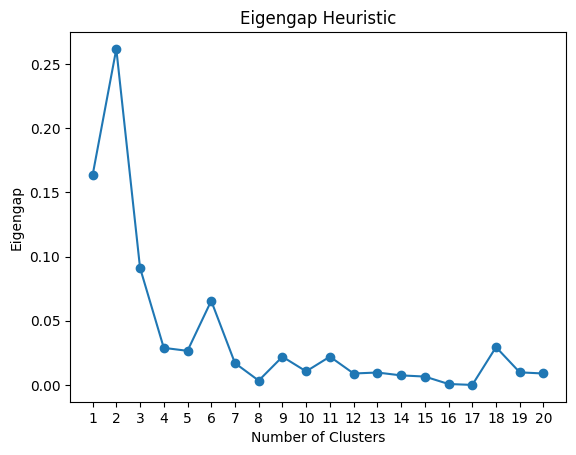

2


In [14]:
similarity_matrix = kneighbors_graph(df_normalized, n_neighbors=10, mode='connectivity', include_self=True)

similarity_matrix = similarity_matrix.toarray()
degree_matrix = np.diag(np.sum(similarity_matrix, axis=1))
laplacian_matrix = degree_matrix - similarity_matrix
eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)
sorted_indices = np.argsort(eigenvalues)
sorted_eigenvalues = eigenvalues[sorted_indices]
eigengaps = np.diff(sorted_eigenvalues)
eigengaps = eigengaps[:20]
optimal_k_index = np.argmax(eigengaps)

# Plot eigengaps
plt.plot(range(1, len(eigengaps) + 1), eigengaps, marker='o')
plt.title('Eigengap Heuristic')
plt.xlabel('Number of Clusters')
plt.ylabel('Eigengap')
plt.xticks(np.arange(1, len(eigengaps) + 1, step=1))  # Adjust step value as needed
plt.show()

optimal_k = optimal_k_index + 1
print(optimal_k)

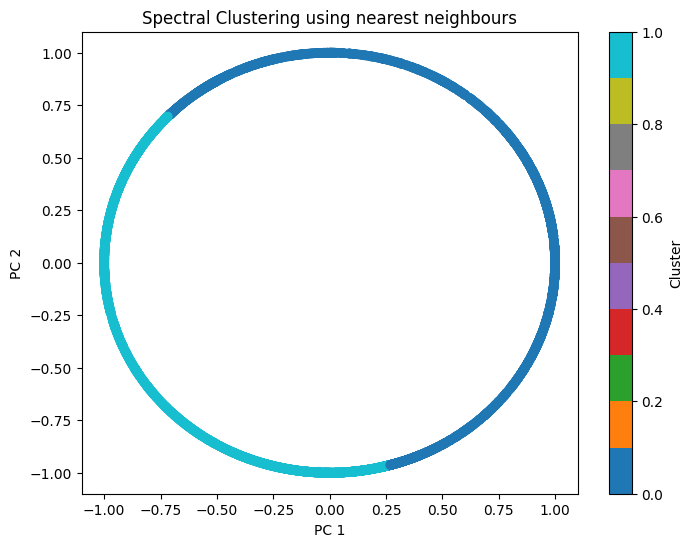

In [15]:
# using nearest_neighbors
spectral_clustering = SpectralClustering(n_clusters=optimal_k, affinity='nearest_neighbors')
nn_labels = spectral_clustering.fit_predict(df_normalized)

plt.figure(figsize=(8, 6))
plt.scatter(df_normalized['PC1'], df_normalized['PC2'], c=nn_labels, cmap='tab10')
plt.title('Spectral Clustering using nearest neighbours')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar(label='Cluster')
plt.show()

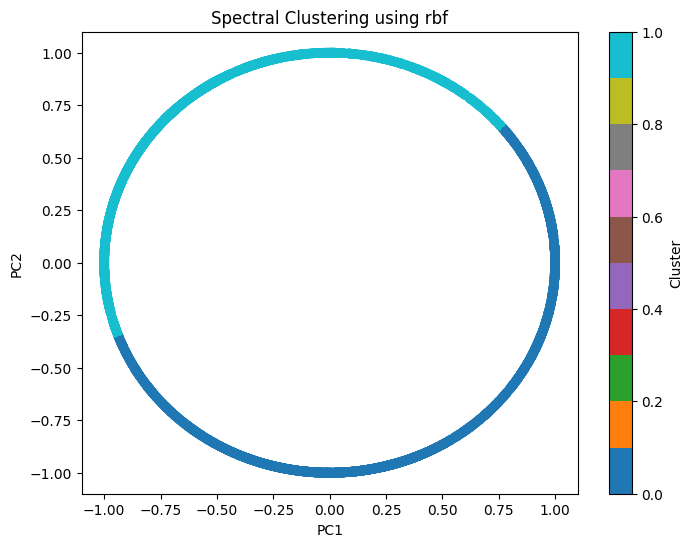

In [16]:
# using rbf
spectral_clustering = SpectralClustering(n_clusters=optimal_k, affinity='rbf')
rbf_labels = spectral_clustering.fit_predict(df_normalized)

plt.figure(figsize=(8, 6))
plt.scatter(df_normalized['PC1'], df_normalized['PC2'], c=rbf_labels, cmap='tab10')
plt.title('Spectral Clustering using rbf')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.show()

Silhouette Score for 'nearest_neighbors' affinity: 0.20545475619621384
Silhouette Score for 'rbf' affinity: 0.39200790742092056


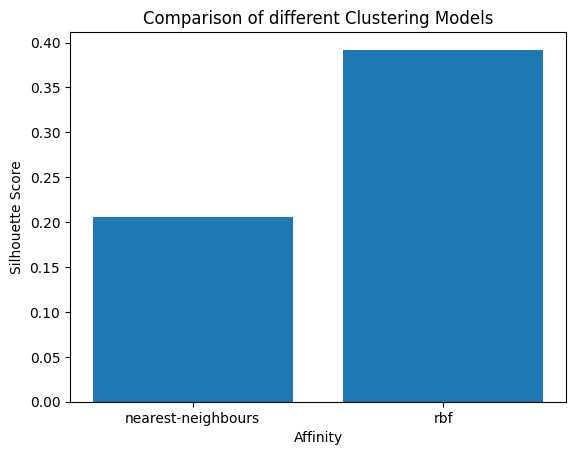

In [17]:
affinity = ['nearest-neighbours', 'rbf']
s_scores = []
s_scores.append(silhouette_score(df_red_samp, nn_labels))
s_scores.append(silhouette_score(df_red_samp, rbf_labels))
print("Silhouette Score for 'nearest_neighbors' affinity:", s_scores[0])
print("Silhouette Score for 'rbf' affinity:", s_scores[1])

# Plotting Bar Graph to compare the Models
plt.bar(affinity, s_scores)
plt.xlabel('Affinity')
plt.ylabel('Silhouette Score')
plt.title('Comparison of different Clustering Models')
plt.show()